In [617]:
import pandas as pd
import numpy as np
import pickle
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


### Data load 

In [618]:
# Data
df = pd.read_csv('data/df.csv')

In [627]:
df.head()

,customer_id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,0,1,0,1,0,2,DSL,0,...,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,0,0,0,0,34,1,0,DSL,1,...,1,0,0,0,One year,0,Mailed check,56.95,1889.5,0
2,3668-QPYBK,0,0,0,0,2,1,0,DSL,1,...,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,0,0,0,0,45,0,2,DSL,1,...,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,1,0,0,0,2,1,0,Fiber optic,0,...,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [629]:
churn_counts = df_final['Churn'].value_counts()
churn_counts

Churn
0    5163
1    1869
Name: count, dtype: int64

### Data exploration

In [602]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [619]:
df.head()

,customer_id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [620]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


### Preprocessing

In [621]:
def convert_dataframe(df):
    # Reemplazar valores en blanco o espacios vacíos con NaN
    df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

    # Convertir columnas binarias
    df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
    df['Partner'] = df['Partner'].map({'No': 0, 'Yes': 1})
    df['Dependents'] = df['Dependents'].map({'No': 0, 'Yes': 1})
    df['PhoneService'] = df['PhoneService'].map({'No': 0, 'Yes': 1})
    df['MultipleLines'] = df['MultipleLines'].map({'No': 0, 'Yes': 1, 'No phone service': 2})
    df['OnlineSecurity'] = df['OnlineSecurity'].map({'No': 0, 'Yes': 1, 'No internet service': 2})
    df['OnlineBackup'] = df['OnlineBackup'].map({'No': 0, 'Yes': 1, 'No internet service': 2})
    df['DeviceProtection'] = df['DeviceProtection'].map({'No': 0, 'Yes': 1, 'No internet service': 2})
    df['TechSupport'] = df['TechSupport'].map({'No': 0, 'Yes': 1, 'No internet service': 2})
    df['StreamingTV'] = df['StreamingTV'].map({'No': 0, 'Yes': 1, 'No internet service': 2})
    df['StreamingMovies'] = df['StreamingMovies'].map({'No': 0, 'Yes': 1, 'No internet service': 2})
    df['PaperlessBilling'] = df['PaperlessBilling'].map({'No': 0, 'Yes': 1})
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

    # Convertir columnas categóricas con One-Hot Encoding
    df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'])

    # Eliminar columnas no numéricas o innecesarias
    df = df.drop(columns=['customer_id'])

    # Asegurarse de que todas las columnas sean numéricas
    df = df.apply(pd.to_numeric, errors='coerce')

    # Eliminar filas con valores NaN
    df.dropna(inplace=True)

    return df

# Cargar el dataframe completo
df = pd.read_csv('data/df.csv') 

# Convertir los datos (limpiar y transformar)
df_final = convert_dataframe(df)

In [622]:
# Dividir en Train y Test csv
dftrain, dftest = train_test_split(df_final, test_size=0.2, random_state=42)

# Guardar los dataframes en archivos CSV
dftrain.to_csv('data/train/train.csv', index=False)
dftest.to_csv('data/test/test.csv', index=False)

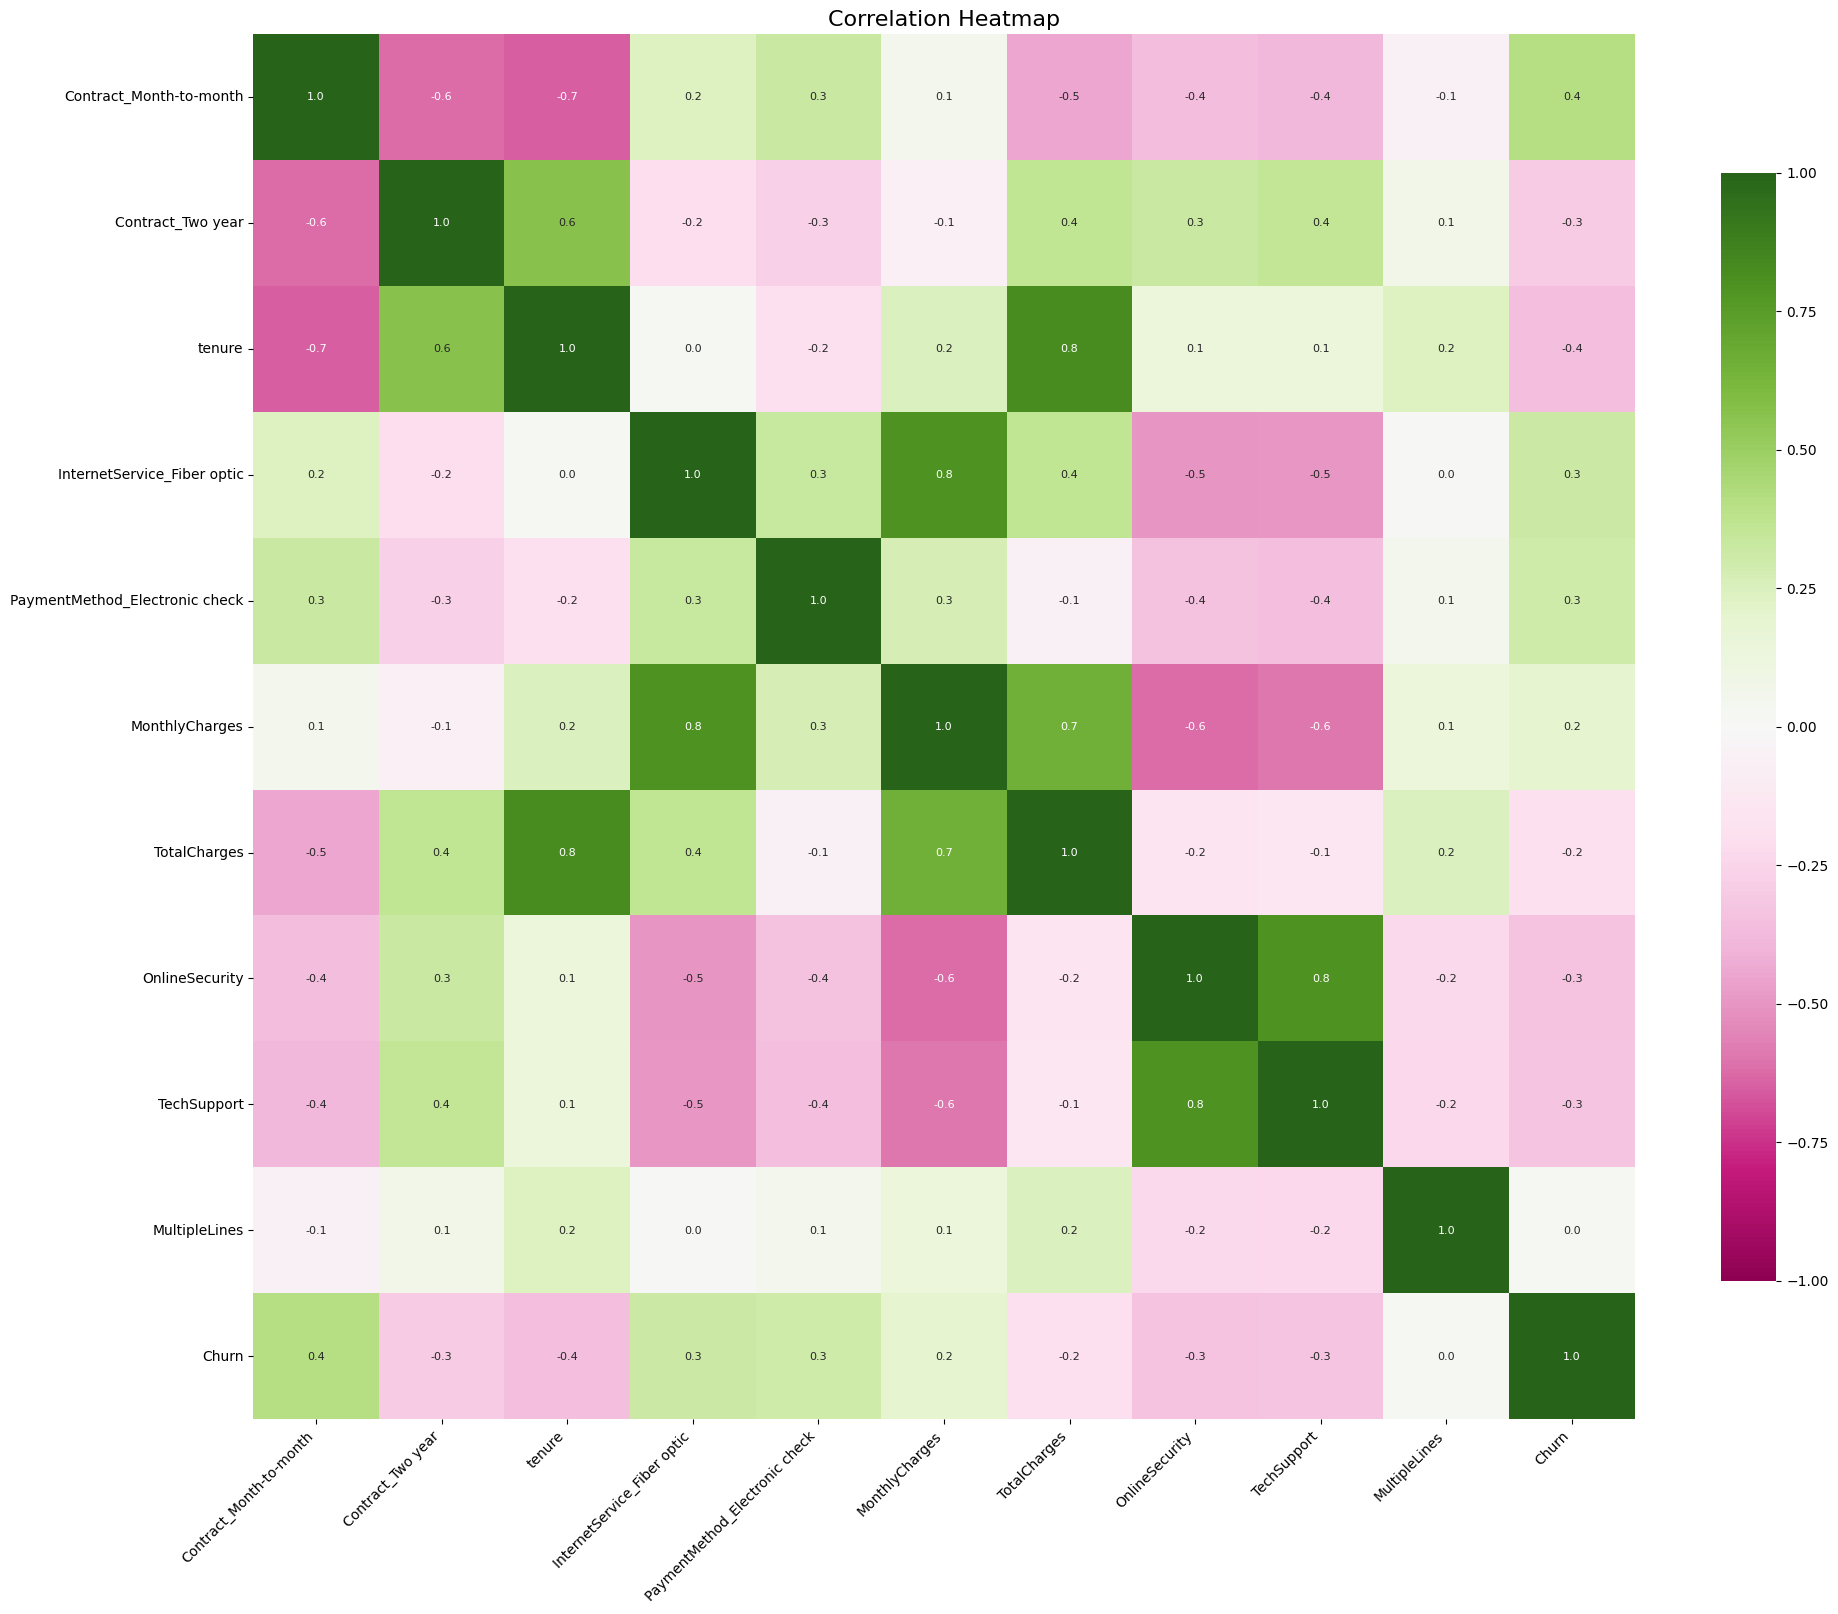

In [661]:
# Seleccionar las variables para el mapa de correlación
X_train = dftrain[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic', 
                   'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity', 
                   'TechSupport', 'MultipleLines', 'Churn']]
y_train = dftrain['Churn']

# Calcular la matriz de correlación
corr_matrix = X_train.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(20, 16))

# Generar el heatmap de correlación
sns.heatmap(corr_matrix, annot=True, cmap='PiYG', fmt='.1f', vmin=-1, vmax=1,
            annot_kws={"size": 8}, cbar_kws={"shrink": .8})

# Rotar las etiquetas para una mejor legibilidad
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
# Ajustar el diseño para una mejor visibilidad
plt.tight_layout()

plt.title('Correlation Heatmap', fontsize=16)
plt.show()

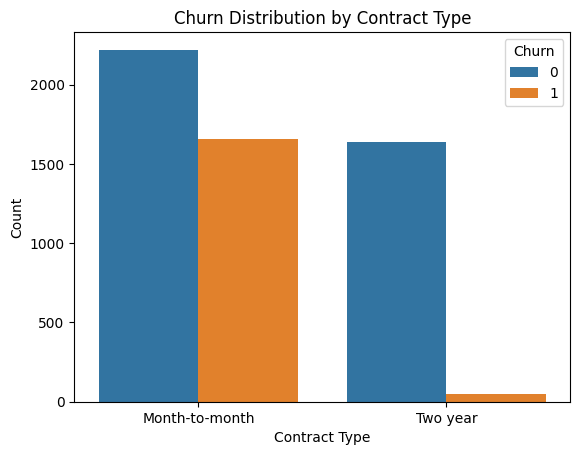

In [649]:
# Crear una nueva columna 'Contract' basada en las columnas One-Hot Encoded para Month-to-month y Two year
df_final['Contract'] = df_final.apply(
    lambda row: 'Month-to-month' if row['Contract_Month-to-month'] == 1 else ('Two year' if row['Contract_Two year'] == 1 else 'Other'),
    axis=1
)

# Filtrar solo Month-to-month y Two year
df_filtered = df_final[df_final['Contract'].isin(['Month-to-month', 'Two year'])]

# Gráfico
sns.countplot(x='Contract', hue='Churn', data=df_filtered)
plt.title('Churn Distribution by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.show()

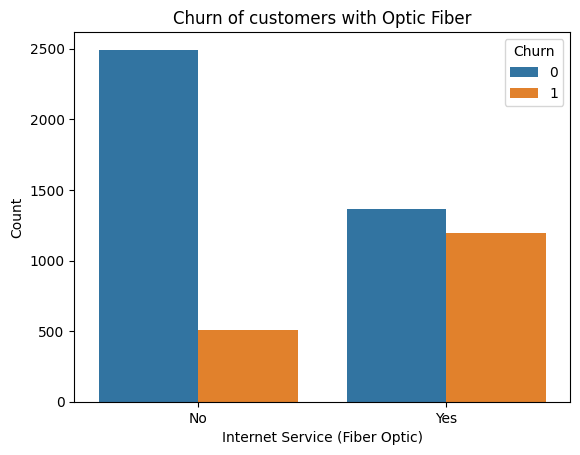

In [659]:
# Gráfico de barras para InternetService_Fiber optic
sns.countplot(x='InternetService_Fiber optic', hue='Churn', data=df_filtered)
plt.title('Churn of customers with Optic Fiber')
plt.xlabel('Internet Service (Fiber Optic)')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])  # Asumiendo que los valores son 0 y 1
plt.show()

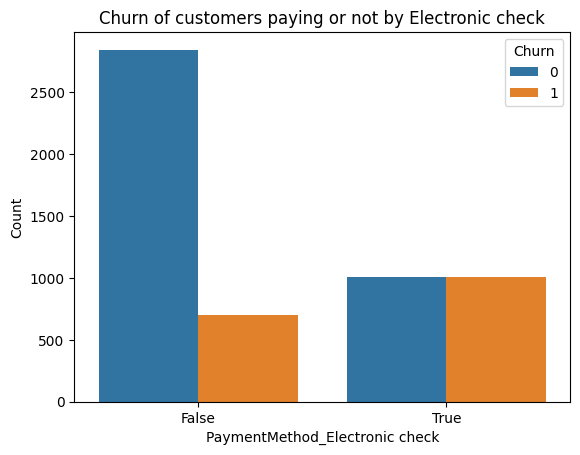

In [647]:
# Gráfico de barras para PaymentMethod
sns.countplot(x='PaymentMethod_Electronic check', hue='Churn', data=df_filtered)
plt.title('Churn of customers paying or not by Electronic check')
plt.xlabel('PaymentMethod_Electronic check')
plt.ylabel('Count')
plt.show()

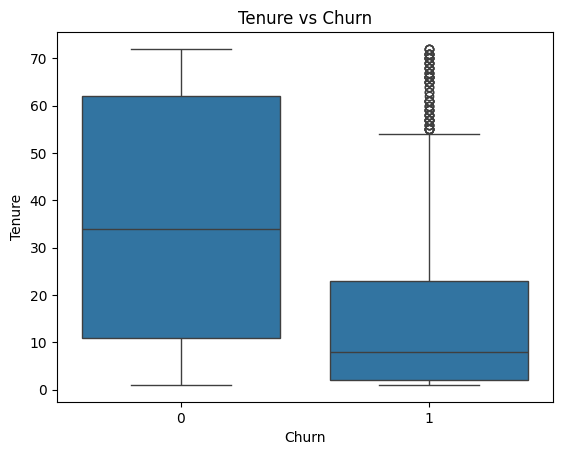

In [650]:
# Boxplot para tenure
sns.boxplot(x='Churn', y='tenure', data=df_filtered)
plt.title('Tenure vs Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure')
plt.show()

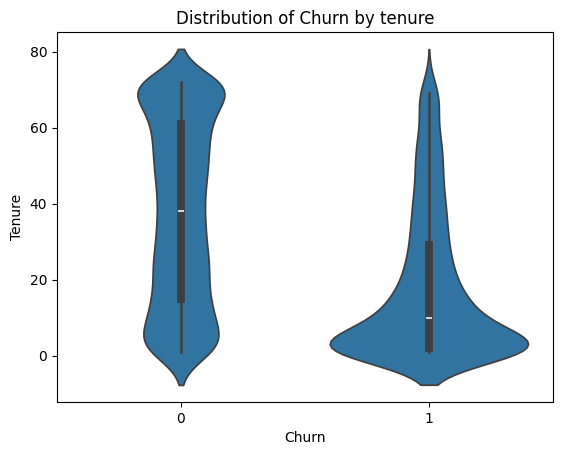

In [660]:
# Gráfica de violín para tenure
sns.violinplot(x='Churn', y='tenure', data=df_final)
plt.title('Distribution of Churn by tenure')
plt.xlabel('Churn')
plt.ylabel('Tenure')
plt.show()

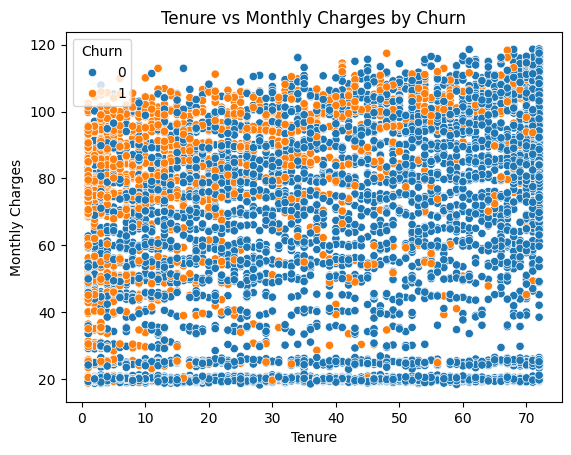

In [656]:
# Gráfica de dispersión para Tenure y MonthlyCharges
sns.scatterplot(x='tenure', y='MonthlyCharges', hue='Churn', data=df_final)
plt.title('Tenure vs Monthly Charges by Churn')
plt.xlabel('Tenure')
plt.ylabel('Monthly Charges')
plt.show()

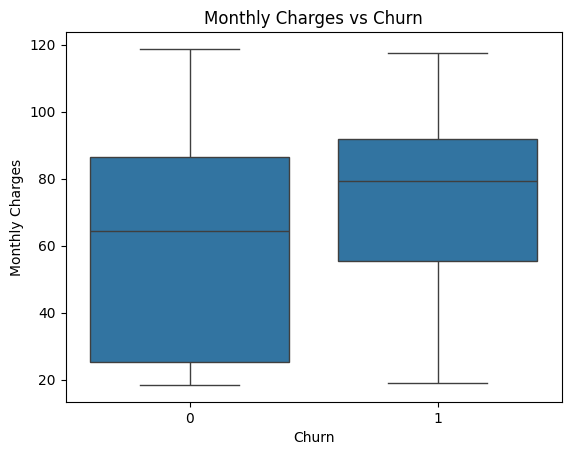

In [651]:
# Boxplot para MonthlyCharges
sns.boxplot(x='Churn', y='MonthlyCharges', data=df_filtered)
plt.title('Monthly Charges vs Churn')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.show()

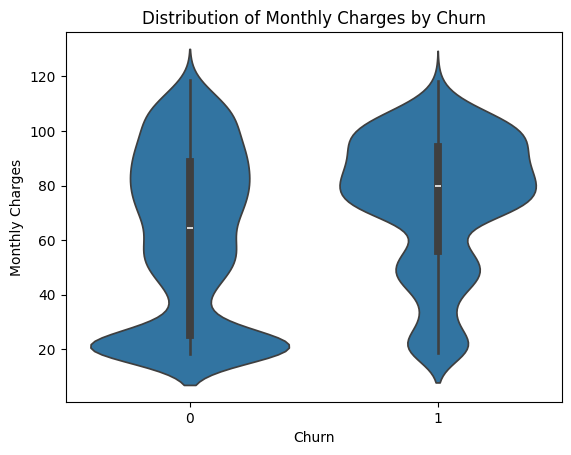

In [654]:
# Gráfica de violín para MonthlyCharges
sns.violinplot(x='Churn', y='MonthlyCharges', data=df_final)
plt.title('Distribution of Monthly Charges by Churn')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.show()

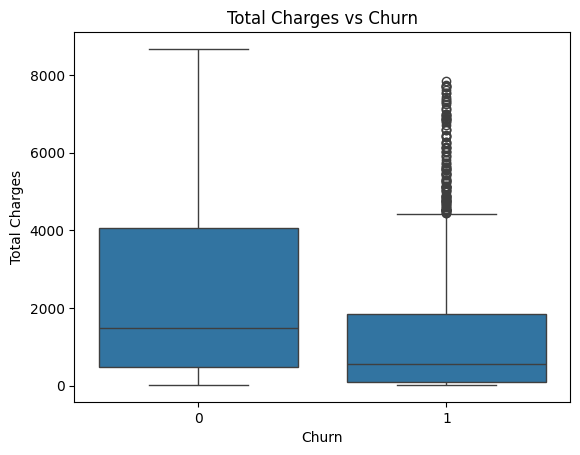

In [652]:
# Boxplot para TotalCharges
sns.boxplot(x='Churn', y='TotalCharges', data=df_filtered)
plt.title('Total Charges vs Churn')
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.show()

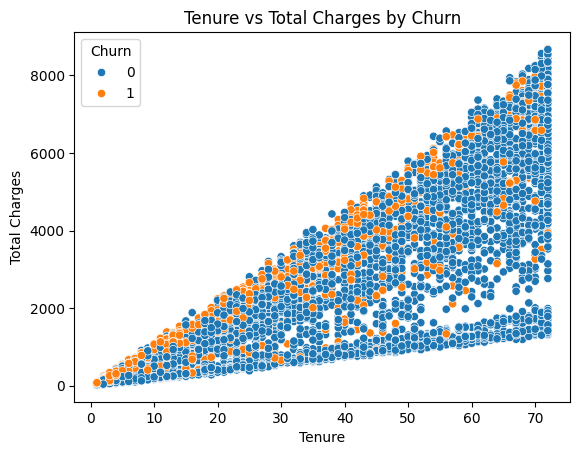

In [657]:
# Gráfica de dispersión para Tenure y TotalCharges
sns.scatterplot(x='tenure', y='TotalCharges', hue='Churn', data=df_final)
plt.title('Tenure vs Total Charges by Churn')
plt.xlabel('Tenure')
plt.ylabel('Total Charges')
plt.show()

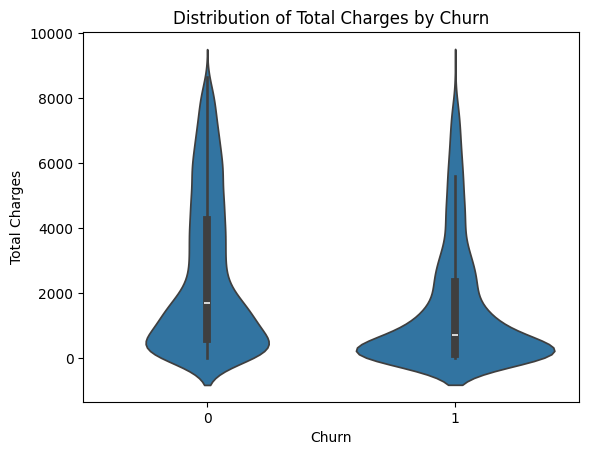

In [655]:
# Gráfica de violín para TotalCharges
sns.violinplot(x='Churn', y='TotalCharges', data=df_final)
plt.title('Distribution of Total Charges by Churn')
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.show()

In [ ]:
# Data
df = pd.read_csv('data/df.csv')

# MODELO

In [624]:
# Separar variables predictoras y variable objetivo
X_train = dftrain[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity', 'TechSupport', 'MultipleLines']]# ACCURACY 0.79, PRECISION 0.83, RECALL: 0.91(GBC)
y_train = dftrain['Churn']
X_test = dftest[['Contract_Month-to-month', 'Contract_Two year', 'tenure', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity', 'TechSupport', 'MultipleLines']]# ACCURACY 0.79, PRECISION 0.83, RECALL: 0.91(GBC)
y_test = dftest['Churn']

### MODELO PIPELINE GBC

In [633]:
# Definir el pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalizar los datos
    ('classifier', GradientBoostingClassifier(random_state=42))  # Clasificador
])

# Entrenar el modelo usando el pipeline
pipeline.fit(X_train, y_train)

# Guardar el pipeline completo en un archivo
with open('models/gbc_pipeline_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# Cargar el pipeline completo desde el archivo
with open('models/gbc_pipeline_model.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

# Predecir en el conjunto de prueba
y_pred = loaded_pipeline.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.86      1033
           1       0.65      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



In [634]:
# Probar con un usuario
with open('models/gbc_pipeline_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
y_pred = loaded_model.predict(X_test[0:1])